<h1 style="font-size:40px;"><center>Exercise III:<br> Image Segmentation using CNNs</center></h1>

Explain what semantic segmentation is!

# Short summary
In this exercise, we will design a CNN-based **encoder-decoder architecture** to segment rgb images. Image segmentation refers to dividing the image into semantically meaningful regions. For instance, representing each object in the scene with a unique color. The current folder has **three files**: 
- **configSegmenter.py:** this involves definitions of all parameters and data paths
- **utilsSegmenter.py:** includes utility functions required to grab and visualize data 
- **runSegmenter.ipynb:** contains the script to design, train and test the network 

Make sure that before running this script, you created an environment and **installed all required libraries** such 
as keras. The very same environment used in Exercise II can be used here as well.

## Data
There exists also a subfolder called **data** which contains the traning, validation, and testing data each has both RGB input images together with the corresponding ground truth segmentation images.

## Writing the report
First the report should be written within this notebook. We have prepared the last cell in this notebook for you where you should write the report. The report should contain 4 parts:

* Name:
* Introduction: A **few** sentences where you give a small introduction of what you have done in the lab.
* Answers to questions: For each of the questions provide an answer. It can be short answers or a longer ones depending on the nature of the questions, but try to be effective in your writing.
* Conclusion: Summarize your findings in a few sentences.
  

# Import packages

In [1]:
%load_ext autoreload
%autoreload 2
# Hacky solution to ac>cess the global utils package
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('..')))

In [2]:
# Torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# local modules
from torch.utils.data import DataLoader
from DL_labs.utils.dataset import SegmentationDataset
from DL_labs.utils import dataloader
from DL_labs.utils.model import Model
from config import flying_objects_config
from collections import OrderedDict
import torchvision
from DL_labs.utils import plot, utils
import pprint

/home/stud/f/fremar16/miniconda3/envs/DL-Labs/lib/python3.9/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


## Load config
Note that this lab does not support for fineGrained dataset.

In [3]:
cfg = flying_objects_config(False)
cfg

{'CLASSES': ['square', 'triangle', 'circular', 'background'],
 'fineGrained': False,
 'NUM_CLASSES': 4,
 'training_img_dir': '../data/FlyingObjectDataset_10K/training',
 'validation_img_dir': '../data/FlyingObjectDataset_10K/validation',
 'testing_img_dir': '../data/FlyingObjectDataset_10K/testing',
 'GPU': -1,
 'IMAGE_WIDTH': 128,
 'IMAGE_HEIGHT': 128,
 'IMAGE_CHANNEL': 3,
 'NUM_WORKERS': 4,
 'BATCH_SIZE': 32,
 'SAVE_EVERY': 1,
 'TENSORBORD_DIR': 'logs/'}

# Example Task
Here is an example of how the network can be setup to train a network to learn semantic segmentation of images.

## Example data
First load the dataloaders for three datasets; train, validation and test. Feel free to test different augmentations, more can be found at *https://pytorch.org/vision/stable/transforms.html*

Note that ToTensor and Rezise are required to reshape and transform the images correct. We do not want to apply augmentation to the test_transform that are applied on the validation and test dataloader.

In [4]:
## Augmentation
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)), #, interpolation=torchvision.transforms.InterpolationMode.NEAREST
    #torchvision.transforms.Lambda(lambda x: utils.normalize(x))
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)), #, interpolation=torchvision.transforms.InterpolationMode.NEAREST
    #torchvision.transforms.Lambda(lambda x: utils.normalize(x))
])

In [5]:
train_dataloader = DataLoader(SegmentationDataset(cfg.training_img_dir, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), transform=train_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=True,
                        num_workers=cfg.NUM_WORKERS)
valid_dataloader = DataLoader(SegmentationDataset(cfg.validation_img_dir, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), transform=test_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)
test_dataloader = DataLoader(SegmentationDataset(cfg.testing_img_dir, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), transform=test_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)

predict_dataloader = DataLoader(SegmentationDataset(cfg.testing_img_dir, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), predict=True, transform=test_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)
print("Data batch generators are created!")

Data batch generators are created!


## Visualise data

In [6]:
data = iter(train_dataloader)

In [7]:
t_x, t_y = next(data)

x (32, 4, 128, 128) torch.float32 0.0 1.0
y (32, 128, 128) torch.int64 0 3


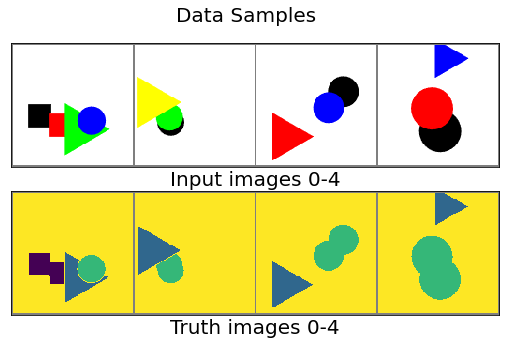

In [8]:
t_x, t_y = next(data)
print(f"x {tuple(t_x.shape)} {t_x.dtype} {t_x.min()} {t_x.max()}")
print(f"y {tuple(t_y.shape)} {t_y.dtype} {t_y.min()} {t_y.max()}")
plot.Segmentation.data(t_x[:,:3], t_y) #t_x.permute(0,2,3,1)

In [9]:
if False: # Change to true to see statistics
    plot.show_statistics(cfg.training_img_dir, fineGrained=cfg.fineGrained, title=" Training Data Statistics ")
    plot.show_statistics(cfg.validation_img_dir, fineGrained=cfg.fineGrained, title=" Validation Data Statistics ")
    plot.show_statistics(cfg.testing_img_dir, fineGrained=cfg.fineGrained, title=" Testing Data Statistics ")

In [10]:
pprint.pprint(cfg)

{'BATCH_SIZE': 32,
 'CLASSES': ['square', 'triangle', 'circular', 'background'],
 'GPU': -1,
 'IMAGE_CHANNEL': 3,
 'IMAGE_HEIGHT': 128,
 'IMAGE_WIDTH': 128,
 'NUM_CLASSES': 4,
 'NUM_WORKERS': 4,
 'SAVE_EVERY': 1,
 'TENSORBORD_DIR': 'logs/',
 'fineGrained': False,
 'testing_img_dir': '../data/FlyingObjectDataset_10K/testing',
 'training_img_dir': '../data/FlyingObjectDataset_10K/training',
 'validation_img_dir': '../data/FlyingObjectDataset_10K/validation'}


## Create model

In [11]:
class SimpleModel(nn.Module):
    def __init__(self,num_classes:int=3, input_shape=(10,10),**kwargs):
        super().__init__()
        self.Encoder = nn.Sequential(
            nn.Conv2d(num_classes, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, num_classes, kernel_size=2, stride=2),
            nn.LeakyReLU()
        )


    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)

        return x

In [12]:
import torchmetrics
# Train model
config = {
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":0.005,
        }
    },
    'criterion':torch.nn.CrossEntropyLoss(), # error function
    'max_epochs':59,
    "train_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.IoU(num_classes=cfg.NUM_CLASSES, compute_on_step=False)
    ],postfix="_Train"),
    "validation_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.IoU(num_classes=cfg.NUM_CLASSES, compute_on_step=False)
    ],postfix="_Validation")
}

In [ ]:
import pytorch_lightning as pl
from DL_labs.utils.progressbar import LitProgressBar
#
# Load model  cfg.NUM_CLASSES
modelObj = Model(SimpleModel(num_classes=cfg.NUM_CLASSES, input_shape=(cfg.IMAGE_CHANNEL, cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),**config)

# Setup trainer
trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=cfg.GPU,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[LitProgressBar()],
            progress_bar_refresh_rate=1,
            weights_summary=None, # Can be None, top or full
            num_sanity_val_steps=10,   
        )
# Train with the training and validation data- 
trainer.fit(
    modelObj, 
    train_dataloader=train_dataloader,
    val_dataloaders=valid_dataloader
);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/stud/f/fremar16/miniconda3/envs/DL-Labs/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Test the network on the test dataset

In [ ]:
# Create iterable from the test dataset
iter_dataloader = iter(test_dataloader)

In [ ]:
# Take one batch from the test dataset and predict!
t_data, t_segments = next(iter_dataloader)
#pred_segments = model.predict(model, batch_size=cfg.BATCH_SIZE)
pred_segments = torch.argmax(modelObj.predict_step(t_data,0,0),dim=1)

plot.segmentation_results(t_data[:,:3], t_segments, pred_segments, cfg.NUM_CLASS)

# Exercises

## Architecture
### Task 2
Even if hyperparameter tuning is an simple approach to improve the performance it might not be enough. Try to modify the architecture of the SimpleModel to further increase the performance. Remember that very deep network allow the network to learn many features but if the dataset is to small the model will underfit. A simple dataset should not require a very deep network to learn good features.

**TODO:** Modify the SimpleModel architecture. Force the network to overfit. How bad performance can you get from the network?

**TODO:** Modify the SimpleModel and increase the complexity a little. Does the performance improve? If not, did you modify it to much or to little?

**TODO:** Modify the SimpleModel architecture. Now combine the hyperparameter tuning and modification of the architecture to reach a performance that is close to the truth images. Explain in detail why the change was applied and if it improved the model a lot.

## Hyperparameter tuning
### Task 1
From the example approach we can see that the network performed very poor. For the network to be consider "good" the truth images should match the predicted images. The first task is to tune the parameters of the network. This mostly involves changing the learning rate, optimizers, loss function etc. to better learn features. A network that have a to high learning rate create a increase in variance of the network weights which can make the network unstable.


**TODO:** Perform hyperparameter tuning. Explain in detail why the parameters was changed and why it is considered "better".

## Augmentation
Test if data augmentation help

In [ ]:
Not sure how to apply augmentation